In [66]:
import rasterio as rio
from rasterio.plot import plotting_extent
import rasterio.plot
import numpy as np
from topolib.subsetDat import subsetBBox;
from topolib import gda_lib;
from pyproj import Proj, transform
from icepyx import icesat2data as ipd
import matplotlib.pyplot as plt 
import sys

%matplotlib inline

In [4]:
!pwd

/home/jovyan/SeasonalSnow/contributors/IsobelLawrence


# Visualize the raster

In [63]:
#ASO is airborne coupled imaging spectrometer (measures snow albedo) and lidar (elevation)

#path to raster
raster_path = '/home/jovyan/shared/data-aragon/ASO_3M_PCDTM_USCOGE_20180908_20180913.tif'
#raster_path = '/home/jovyan/shared/data-aragon/ASO_3M_PCDTM_USCOCM_20180912_20180913.tif'
#raster_path = '/home/jovyan/shared/data-aragon/ASO_3M_PCDTM_USCOGT_20180912_20180913.tif'
#raster_path = '/home/jovyan/shared/data-aragon/ASO_3M_PCDTM_USCATE_20191010_20191010.tif'



In [64]:
ds = rio.open(raster_path)
dem = ds.read(1)
dem = np.ma.masked_equal(dem,gda_lib.get_ndv(ds))
xmin,ymin,xmax,ymax = ds.bounds
ds.crs

CRS.from_epsg(32613)

In [65]:
print(xmax-xmin,ymax-ymin)

46224.0 51639.0


In [53]:
raster = rio.open(raster_path)
raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 8223,
 'height': 7709,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(3.0, 0.0, 325728.0,
        0.0, -3.0, 4338204.0)}

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

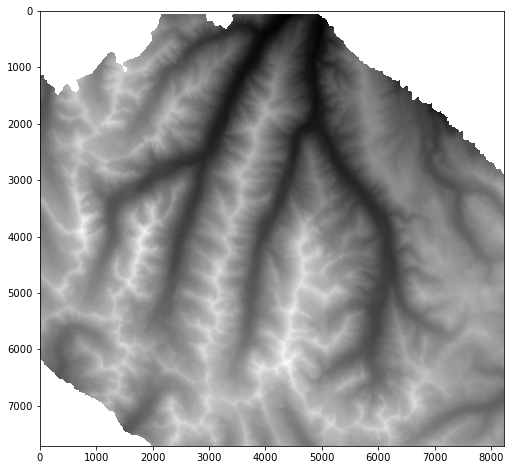

In [54]:
fig,ax = plt.subplots(figsize=(10,8))

rio.plot.show(dem, ax=ax,cmap='gray')

In [55]:
[L,B,R,T] = subsetBBox(raster_path,raster.crs,'epsg:4326') # now read projection from DEM, convert to WGS84
    #[L,B,R,T] = subsetBBox(raster,'epsg:32611','epsg:4326')
    # Area of interest
boundaries = {
    'LowerLeft_Lon': L,
    'LowerLeft_Lat': B,
    'UpperRight_Lon': R,
    'UpperRight_Lat': T,
}
L,B,R,T

(-107.01155869847894,
 38.96734379430441,
 -106.73203034767475,
 39.18021193653812)

# Find Icesat2 data within domain
From intro-is-files Notebook

In [56]:
from pathlib import Path

# Our data folder 
#data_home = Path('/home/jovyan/tutorial-data/land_ice_applications/PIG_ATL06')
data_home = Path('/home/jovyan/shared/data-Isobel_Rosie/ATL03')
                 
# Create folder if it doesn't exist
data_home.mkdir(exist_ok=True)

In [57]:
from icepyx import icesat2data as ipd

short_name = 'ATL03'
spatial_extent = [L,B,R,T]
date_range = ['2018-01-01','2020-06-17']

# spatial_extent = [148, -81, 162, -80]  # Byrd
# date_range = ['2018-10-14','2018-12-22']

region = ipd.Icesat2Data(short_name, spatial_extent, date_range)

product:     ATL03
dates:       ['2018-01-01', '2020-06-17']
start time:  00:00:00
end time:    23:59:59
version:     003
extent:      ['bounding box', [-107.01155869847894, 38.96734379430441, -106.73203034767475, 39.18021193653812]]

DATA:
('Number of available granules', 25)
('Average size of granules (MB)', 2324.204226875312)
('Total size of all granules (MB)', 58105.10567188279)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

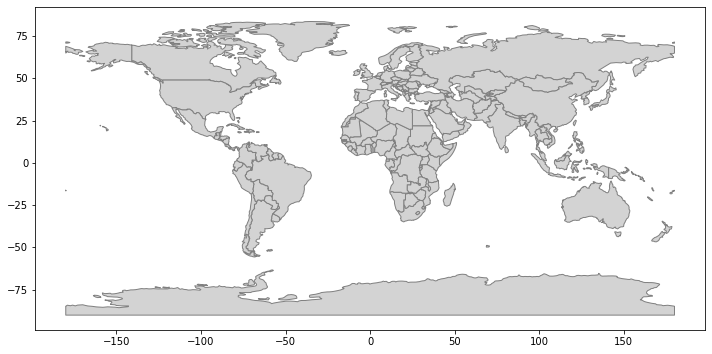

In [58]:
print('product:    ', region.dataset)
print('dates:      ', region.dates)
print('start time: ', region.start_time)
print('end time:   ', region.end_time)
print('version:    ', region.dataset_version)
print('extent:     ', region.spatial_extent)

print('\nDATA:')
print('\n'.join([str(item) for item in region.avail_granules().items()]))

region.visualize_spatial_extent()

In [59]:
#build and view the parameters that will be submitted in our query
region.CMRparams

{'short_name': 'ATL03',
 'version': '003',
 'temporal': '2018-01-01T00:00:00Z,2020-06-17T23:59:59Z',
 'bounding_box': '-107.01155869847894,38.96734379430441,-106.73203034767475,39.18021193653812'}

In [14]:
#get a list of the available granule IDs that meet your search criteria
region.avail_granules(ids=True)

['ATL03_20191008052407_01730502_003_01.h5']

# Download the data

In [15]:
name = 'isobelrlawrence'
email = 'isobel.lawrence.15@ucl.ac.uk'

for file in region.avail_granules(ids=True):
    print(file)
    if not list(data_home.glob('*'+file+'*')):
        print('you dont have the file')
        region.earthdata_login(name, email)
        region.download_granules(data_home)
# Only download if data folder is empty
#if not list(data_home.glob('*.h5')):
#    region.earthdata_login(name, email)
#    region.download_granules(data_home)

ATL03_20191008052407_01730502_003_01.h5


In [16]:
files = list(data_home.glob('*.h5'))

for f in files[:10]: print(f)
print('Total number of files:', len(files))

/home/jovyan/shared/data-Isobel_Rosie/ATL03/processed_ATL03_20191008052407_01730502_003_01.h5
Total number of files: 1


# Plot the ATL03 data 
From land_ice_applications Notebook

In [17]:
# the usual suspects:
import numpy as np
import matplotlib.pyplot as plt

# specialty modules
import h5py
import pyproj

# run matplotlib in 'widget' mode
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [47]:
#from readers.read_HDF5_ATL03 import read_HDF5_ATL03
#from readers.get_ATL03_x_atc import get_ATL03_x_atc

from read_HDF5_ATL03 import read_HDF5_ATL03
from get_ATL03_x_atc import get_ATL03_x_atc

In [28]:
data_root='/home/jovyan/shared/data-aragon/'

In [40]:
import os
import glob

rgt="0615"
cycle="04"
glob.glob(os.path.join(data_root, 'download', f'*{rgt}{cycle}*.h5'))

['/home/jovyan/shared/data-aragon/download/processed_ATL03_20190807082015_06150402_003_01.h5']

In [48]:
read_HDF5_ATL03

<function read_HDF5_ATL03.read_HDF5_ATL03(FILENAME, ATTRIBUTES=True, VERBOSE=False)>

In [49]:
# read the data:
rgt="0615"
cycle="04"
# read the IS2 data with Tyler's ATL03 reader:
ATL03_file=glob.glob(os.path.join(data_root, 'download', f'*{rgt}{cycle}*.h5'))[0]
print(ATL03_file)
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams =read_HDF5_ATL03(ATL03_file)
# add x_atc to the ATL03 data structure (this function adds to the LS2_ATL03_mds dictionary)
get_ATL03_x_atc(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)

/home/jovyan/shared/data-aragon/download/processed_ATL03_20190807082015_06150402_003_01.h5


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

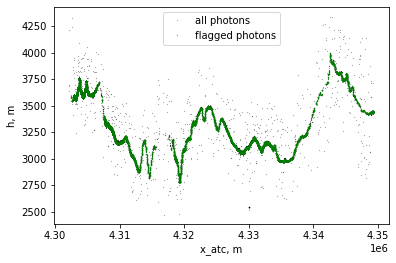

In [50]:
#-- select the beam from ATL03
D3 = IS2_atl03_mds['gt3l']

#-- create scatter plot of photon data (e.g., photon elevation vs x_atc)
fig=plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(D3['heights']['x_atc'], D3['heights']['h_ph'],'k.',markersize=0.25, label='all photons')
LMH=D3['heights']['signal_conf_ph'][:,3] >= 2
ax.plot(D3['heights']['x_atc'][LMH], D3['heights']['h_ph'][LMH],'g.',markersize=0.5, label='flagged photons')
h_leg=ax.legend()

ax.set_xlabel('x_atc, m')
ax.set_ylabel('h, m')
plt.show()